# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Нам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

**Ход работы:**
1. Загрузка данных, путь к файлу: /datasets/autos.csv.
2. Изучение данных. Заполнить пропущенные значения и обработать аномалии в столбцах. Если среди признаков имеются неинформативные, удалитье их.
3. Подготовка выборки для обучения моделей.
4. Обучение разных моделей, одна из которых — LightGBM, как минимум одна — не бустинг. Для каждой модели попробовать разные гиперпараметры.
5. Проанализировать время обучения, время предсказания и качество моделей.
6. Опираясь на критерии заказчика, выбрать лучшую модель, проверить её качество на тестовой выборке.

**Примечания:**
- Для оценки качества моделей применить метрику RMSE.
- Значение метрики RMSE должно быть меньше 2500.
- Освоение библиотеки LightGBM и её средствами построить модели градиентного бустинга.
- Время выполнения ячейки кода Jupyter Notebook можно получить специальной командой. Найти её.
- Модель градиентного бустинга может долго обучаться, поэтому неободимо изменить у неё только два-три параметра.
- Если перестанет работать Jupyter Notebook, удалите лишние переменные оператором del.

**Описание данных:**
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- NotRepaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя
- Price — цена (евро) - **целевой признак**

## Подготовка данных

In [1]:
# Импорты

import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

In [2]:
# Загрузка данных

df = pd.read_csv('/datasets/autos.csv')

In [3]:
# Проверяем, что таблица загружена корректно, разделители верные
df

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26


### Предварительная подготовка данных

Приведём наименования столбцов к общепринятому стилю:

In [4]:
df.columns

Index(['DateCrawled', 'Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand',
       'NotRepaired', 'DateCreated', 'NumberOfPictures', 'PostalCode',
       'LastSeen'],
      dtype='object')

In [5]:
df = df.rename(columns={
    'DateCrawled': 'date_crawled',
    'Price': 'price',
    'VehicleType': 'vehicle_type',
    'RegistrationYear': 'registration_year',
    'Gearbox': 'gearbox',
    'Power': 'power',
    'Model': 'model',
    'Kilometer': 'mileage', #поэтому не использую простое приведение к нижнему регистру
    'RegistrationMonth': 'registration_month',
    'FuelType': 'fuel_type',
    'Brand': 'brand',
    'NotRepaired': 'not_repaired',
    'DateCreated': 'date_created', #уточнить отличие от date_crawled
    'NumberOfPictures': 'pictures_count',
    'PostalCode': 'postcode',
    'LastSeen': 'last_seen'
})

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        354369 non-null  object
 1   price               354369 non-null  int64 
 2   vehicle_type        316879 non-null  object
 3   registration_year   354369 non-null  int64 
 4   gearbox             334536 non-null  object
 5   power               354369 non-null  int64 
 6   model               334664 non-null  object
 7   mileage             354369 non-null  int64 
 8   registration_month  354369 non-null  int64 
 9   fuel_type           321474 non-null  object
 10  brand               354369 non-null  object
 11  not_repaired        283215 non-null  object
 12  date_created        354369 non-null  object
 13  pictures_count      354369 non-null  int64 
 14  postcode            354369 non-null  int64 
 15  last_seen           354369 non-null  object
dtypes:

В данных содержится большое количество пропусков в наиболее важных признаках:

In [7]:
df.isnull().sum()

date_crawled              0
price                     0
vehicle_type          37490
registration_year         0
gearbox               19833
power                     0
model                 19705
mileage                   0
registration_month        0
fuel_type             32895
brand                     0
not_repaired          71154
date_created              0
pictures_count            0
postcode                  0
last_seen                 0
dtype: int64

К сожалению, пропуски в указанных столбцах восстановить невозможно, так как автомобили одной модели могут иметь разные типы кузова, иметь разную коробку передач и тип топлива. Так как информация по указанным признакам может стать ключевой для пользователей и клиентов, заполнять ориентировочными значениями не будем.

В столбце "not_repaired" также имеется большое количество пропусков. В случае с автомобилями пропуск может означать "yes", т.к. пользователь не посчитал нужным это уточнять, а может значить "no" с целью скрыть ремонт и не попасть в нежелательные фильтры при фильтрации таблицы. Решение о работе с пропусками примем далее в ходе исследования.

In [8]:
# Проверяем на дубликаты

df.duplicated().sum()

4

Так как в столбце 'date_crawled' указаны значения с точностью до секунды, вероятность того, что строки являются не дублями, а двумя разными объектами, околонулевая. Удалим дубли.

In [9]:
df = df.drop_duplicates().reset_index(drop=True)

Рассмотрим параметры массивов в датафрейме:

In [10]:
df.describe()

,price,registration_year,power,mileage,registration_month,pictures_count,postcode
count,354365.000000,354365.000000,354365.000000,354365.000000,354365.000000,354365.0,354365.000000
mean,4416.679830,2004.234481,110.093816,128211.363989,5.714650,0.0,50508.503800
std,4514.176349,90.228466,189.851330,37905.083858,3.726432,0.0,25783.100078
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


В значениях присутствуют аномалии:
1. Минимальная цена - 0 евро;
2. Минимальный год регистрации - 1000, максимальный год регистрации - 9999;
3. Мощность двигателя: минимальная - 0, максимальная 20000 (возможно, это вертолёт с газотурбинными двигателями - проверим);
4. Месяц регистрации - неизвестно с какого числа идёт отсчёт - проверить объекты с 0 и 12;
5. Количество изображений - 0.

Рассмотрим распределение категориальных признаков, заодно проверим наличие скрытых дублей:

In [11]:
for i in df.select_dtypes('object').columns:
    display(i)
    display(df[i].value_counts())

'date_crawled'

2016-03-24 14:49:47    7
2016-03-26 22:57:31    6
2016-03-19 21:49:56    6
2016-03-26 10:51:07    5
2016-03-16 17:43:49    5
                      ..
2016-04-01 08:56:03    1
2016-04-04 17:48:02    1
2016-03-13 08:49:00    1
2016-03-08 14:50:46    1
2016-03-21 14:49:52    1
Name: date_crawled, Length: 271174, dtype: int64

'vehicle_type'

sedan          91457
small          79830
wagon          65165
bus            28775
convertible    20203
coupe          16161
suv            11996
other           3288
Name: vehicle_type, dtype: int64

'gearbox'

manual    268249
auto       66283
Name: gearbox, dtype: int64

'model'

golf                  29232
other                 24420
3er                   19761
polo                  13066
corsa                 12570
                      ...  
i3                        8
serie_3                   4
rangerover                4
serie_1                   2
range_rover_evoque        2
Name: model, Length: 250, dtype: int64

'fuel_type'

petrol      216349
gasoline     98719
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: fuel_type, dtype: int64

'brand'

volkswagen        77012
opel              39931
bmw               36914
mercedes_benz     32044
audi              29456
ford              25179
renault           17927
peugeot           10998
fiat               9643
seat               6907
mazda              5615
skoda              5500
smart              5246
citroen            5148
nissan             4941
toyota             4606
hyundai            3587
sonstige_autos     3374
volvo              3210
mini               3202
mitsubishi         3022
honda              2817
kia                2465
suzuki             2322
alfa_romeo         2314
chevrolet          1754
chrysler           1439
dacia               900
daihatsu            806
subaru              762
porsche             758
jeep                677
trabant             589
land_rover          545
daewoo              542
saab                526
jaguar              505
rover               486
lancia              471
lada                225
Name: brand, dtype: int64

'not_repaired'

no     247158
yes     36053
Name: not_repaired, dtype: int64

'date_created'

2016-04-03 00:00:00    13718
2016-04-04 00:00:00    13317
2016-03-20 00:00:00    12918
2016-03-12 00:00:00    12840
2016-03-21 00:00:00    12691
                       ...  
2015-11-17 00:00:00        1
2015-11-12 00:00:00        1
2015-08-07 00:00:00        1
2015-12-17 00:00:00        1
2016-01-15 00:00:00        1
Name: date_created, Length: 109, dtype: int64

'last_seen'

2016-04-06 13:45:54    17
2016-04-06 09:17:58    16
2016-04-06 10:15:26    16
2016-04-06 08:46:30    16
2016-04-06 09:46:00    16
                       ..
2016-03-28 16:17:46     1
2016-04-04 10:45:56     1
2016-04-03 11:48:01     1
2016-04-01 16:42:02     1
2016-03-20 13:37:40     1
Name: last_seen, Length: 179150, dtype: int64

In [12]:
df.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'mileage', 'registration_month', 'fuel_type', 'brand',
       'not_repaired', 'date_created', 'pictures_count', 'postcode',
       'last_seen'],
      dtype='object')

In [13]:
df.vehicle_type.value_counts()

sedan          91457
small          79830
wagon          65165
bus            28775
convertible    20203
coupe          16161
suv            11996
other           3288
Name: vehicle_type, dtype: int64

In [14]:
df.gearbox.value_counts()

manual    268249
auto       66283
Name: gearbox, dtype: int64

In [15]:
df.model.unique()

array(['golf', nan, 'grand', 'fabia', '3er', '2_reihe', 'other', 'c_max',
       '3_reihe', 'passat', 'navara', 'ka', 'polo', 'twingo', 'a_klasse',
       'scirocco', '5er', 'meriva', 'arosa', 'c4', 'civic', 'transporter',
       'punto', 'e_klasse', 'clio', 'kadett', 'kangoo', 'corsa', 'one',
       'fortwo', '1er', 'b_klasse', 'signum', 'astra', 'a8', 'jetta',
       'fiesta', 'c_klasse', 'micra', 'vito', 'sprinter', '156', 'escort',
       'forester', 'xc_reihe', 'scenic', 'a4', 'a1', 'insignia', 'combo',
       'focus', 'tt', 'a6', 'jazz', 'omega', 'slk', '7er', '80', '147',
       '100', 'z_reihe', 'sportage', 'sorento', 'v40', 'ibiza', 'mustang',
       'eos', 'touran', 'getz', 'a3', 'almera', 'megane', 'lupo', 'r19',
       'zafira', 'caddy', 'mondeo', 'cordoba', 'colt', 'impreza',
       'vectra', 'berlingo', 'tiguan', 'i_reihe', 'espace', 'sharan',
       '6_reihe', 'panda', 'up', 'seicento', 'ceed', '5_reihe', 'yeti',
       'octavia', 'mii', 'rx_reihe', '6er', 'modus', 'fox'

 Несмотря на различный стиль написания, скрытые дубли отсутствуют.

In [16]:
df.fuel_type.value_counts()

petrol      216349
gasoline     98719
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: fuel_type, dtype: int64

In [17]:
df.brand.unique()

array(['volkswagen', 'audi', 'jeep', 'skoda', 'bmw', 'peugeot', 'ford',
       'mazda', 'nissan', 'renault', 'mercedes_benz', 'opel', 'seat',
       'citroen', 'honda', 'fiat', 'mini', 'smart', 'hyundai',
       'sonstige_autos', 'alfa_romeo', 'subaru', 'volvo', 'mitsubishi',
       'kia', 'suzuki', 'lancia', 'toyota', 'chevrolet', 'dacia',
       'daihatsu', 'trabant', 'saab', 'chrysler', 'jaguar', 'daewoo',
       'porsche', 'rover', 'land_rover', 'lada'], dtype=object)

"Rover" - действительно существующий бренд автомобилей, не имеющий в 20 веке отношения к Land Rover, но компания была упразднена в 2005 году. Проверим, что наше умозаключение правдиво:

In [18]:
df.query('brand == "rover"').registration_year.value_counts()

2000    85
1999    83
1998    68
2001    46
1997    31
2003    28
1996    26
2017    22
2016    21
2004    16
2005    11
2002    10
1995    10
1994     5
2018     4
1992     3
2006     3
1993     2
1972     2
1966     1
1991     1
1990     1
1986     1
1984     1
1983     1
1976     1
2007     1
1970     1
1688     1
Name: registration_year, dtype: int64

Наше предположение не подтвердилось, имеются автомобили до 2018 года. Помимо этого, имеется автомобиль 1688 года, что также является ложью. Проверим модели:

In [19]:
df.query('brand == "rover"').model.value_counts()

other         394
rangerover      4
freelander      3
discovery       2
defender        1
Name: model, dtype: int64

В списке перечислены автомобили, относящиеся к бренду Land Rover. Таким образом, допускаем, что все модельные автомобили младше 2005 года также относятся к Land Rover. 
Судя по выведенному распределению, отказываемся от замены пропусков на значение "other" - так как в "other" могут указываться редкие автомобили не из перечня популярных моделей, тогда как пропуск может обозначать любую модель автомобиля.

In [20]:
df.not_repaired.value_counts()

no     247158
yes     36053
Name: not_repaired, dtype: int64

Посмотрим на распределение индексов, ожидаем увидеть хаотичный график.

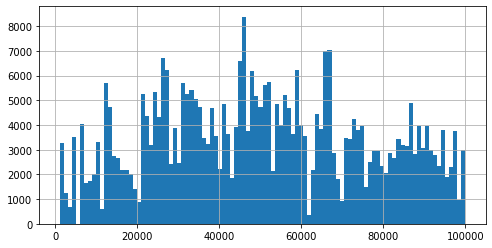

In [21]:
df.postcode.hist(bins=100, figsize=(8,4));

Возможно, страна, регион, континент могут влиять на стоимость автомобиля, в таком случае необходимо распределить индексы по различным категориям, но так как в данной работе это нецелесообразно и может привести к отсутствию улучшений в обучении моделей, в дальнейшем удалим признак с индексами.

Возможно, в данных имеется утечка признака, рассмотрим матрицу корреляций:

In [22]:
df.corr()

,price,registration_year,power,mileage,registration_month,pictures_count,postcode
price,1.000000,0.026916,0.158872,-0.333207,0.110580,NaN,0.076058
registration_year,0.026916,1.000000,-0.000828,-0.053448,-0.011619,NaN,-0.003459
power,0.158872,-0.000828,1.000000,0.024006,0.043379,NaN,0.021662
mileage,-0.333207,-0.053448,0.024006,1.000000,0.009575,NaN,-0.007685
registration_month,0.110580,-0.011619,0.043379,0.009575,1.000000,NaN,0.013996
pictures_count,NaN,NaN,NaN,NaN,NaN,NaN,NaN
postcode,0.076058,-0.003459,0.021662,-0.007685,0.013996,NaN,1.000000


Как и ожидалось, имеется очень слабая отрицательная корреляция между ценой и километражом, а также незначительная корреляция между ценой и мощностью двигателя. Остальные коэффициенты не имеют значения.

**Вывод**

Были изучены данные для последующего анализа. Для дальнейшей корректной работы необходимо провести ряд операций:
1. Удалим признаки, которые не влияют на прогнозирование цены: 'registration_month', 'pictures_count', 'postcode', 'date_crawled', 'last_seen', 'date_created'. Это также избавит нас от предобработки ненужных признаков;
2. Заменим ошибочные модели бренда Rover на Land Rover;
3. Изучим распределение цен и избавимся от выбросов;
4. Изучим годы регистрации и избавимся от некорректных значений;
5. Изучим мощности двигателей и избавимся от некорректных значений;
6. Рассмотрим пропуски и примем решение об удалении или заполнении пропусков.

### Предобработка данных

Удалим ненужные признаки.

In [23]:
df = df.drop(['registration_month', 'pictures_count', 'postcode', 'date_crawled', 'last_seen', 'date_created'], axis=1)

In [24]:
df.columns

Index(['price', 'vehicle_type', 'registration_year', 'gearbox', 'power',
       'model', 'mileage', 'fuel_type', 'brand', 'not_repaired'],
      dtype='object')

In [25]:
df.loc[(df.registration_year > 2005), 'brand'] = 'land_rover'

In [26]:
#Проверяем
df.query('brand == "rover"').model.value_counts()

other         361
freelander      3
rangerover      2
discovery       2
defender        1
Name: model, dtype: int64

Ошибки сохраняются. Переименуем дополнительно бренды с указанными моделями.

In [27]:
df.loc[(df.model.isin(['freelander', 'rangerover', 'discovery', 'defender'])), 'brand'] = 'land_rover'

In [28]:
df.query('brand == "rover"').model.value_counts()

other    361
Name: model, dtype: int64

Рассмотрим распределение цен:

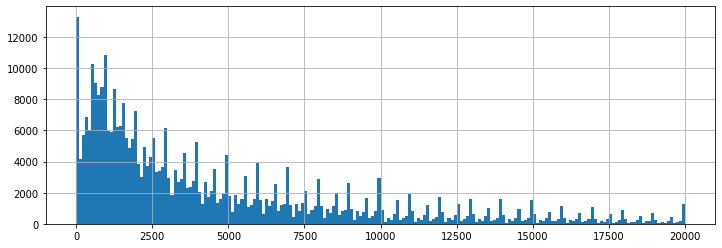

In [29]:
df.price.hist(bins=200, figsize=(12,4));

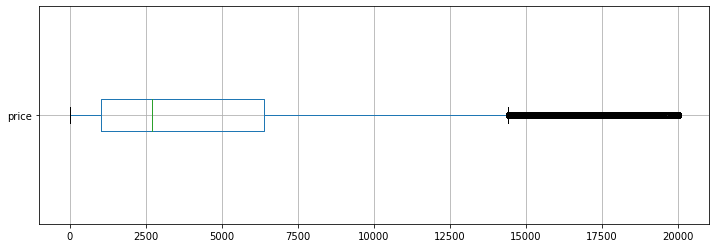

In [30]:
df.boxplot('price', figsize=(12,4), vert=0);

Автомобили - товар, который не имеет максимального предела цены. В целом, распределение похоже на скошенное нормальное, как и ожидалось. Известно, что наиболее часто цены округляются, что выглядит как пилящий график. Из того можно сделать вывод, что данные корректные, за исключением товаров с нулевой стоимостью. Рассмотрим некоторые из этих объектов:

In [31]:
df.query('price == 0')

,price,vehicle_type,registration_year,gearbox,power,model,mileage,fuel_type,brand,not_repaired
7,0,sedan,1980,manual,50,other,40000,petrol,volkswagen,no
40,0,NaN,1990,NaN,0,corsa,150000,petrol,opel,NaN
111,0,NaN,2017,manual,0,golf,5000,petrol,land_rover,NaN
115,0,small,1999,NaN,0,NaN,5000,petrol,volkswagen,NaN
152,0,bus,2004,manual,101,meriva,150000,lpg,opel,yes
...,...,...,...,...,...,...,...,...,...,...
354201,0,NaN,2000,manual,65,corsa,150000,NaN,opel,yes
354234,0,small,2002,manual,60,fiesta,150000,petrol,ford,NaN
354244,0,small,1999,manual,53,swift,150000,petrol,suzuki,NaN
354273,0,small,1999,manual,37,arosa,150000,petrol,seat,yes


В большинстве строк имеются пропуски в остальных признаках. Возможно, в этом есть зависимость, проверим:

In [32]:
df.query('price == 0').isnull().sum()

price                   0
vehicle_type         3740
registration_year       0
gearbox              2478
power                   0
model                2184
mileage                 0
fuel_type            3436
brand                   0
not_repaired         5288
dtype: int64

Наше предположение подтвердилось: если в начальном датафрейме встречалось от 5% до 20% пропущенных значений в разных столбцах, то теперь - от 20% до 49%. Возможно, пользователи относились к заполнению данных менее ответственно для определённых автомобилей. В остальном зависимостей не обнаружили.

Объекты без стоимости не имеют ценности для дальнейшей работы, очистим датафрейм от этих значений.

In [33]:
df = df.query('price != 0')

Рассмотрим распределение низких цен на автомобили, постараемся найти предел, с которого начинаются автомобили, не являющиеся выбросами:

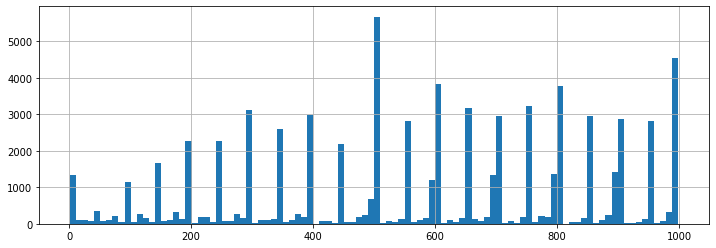

In [34]:
df.query('price < 1000').price.hist(bins=100, figsize=(12,4));

Чёткое разделение автомобилей "на ходу" и "металлолома" отсутствует, имеется только один чёткий пик на общем графике и малые пики на круглых значениях. Чтобы избавиться от части слишком малых стоимостей, удалим 1,5% самых низких значений.

In [35]:
# Проверяем, какой предел устанавливаем
df.price.quantile(.015)

150.0

In [36]:
df = df.query('price >= 150')

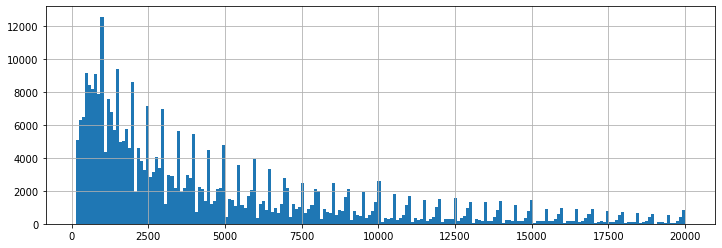

In [37]:
df.price.hist(bins=200, figsize=(12,4));

Рассмотрим года:

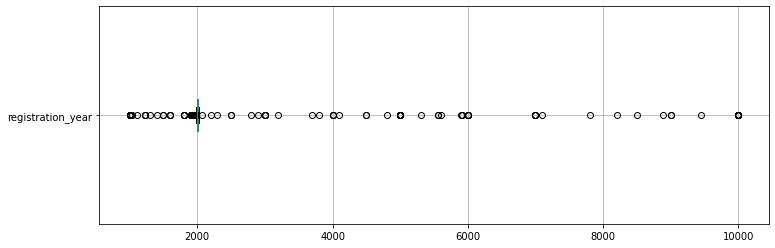

In [38]:
df.boxplot('registration_year', figsize=(12,4), vert=0);

В первую очередь очистим датафрейм от будущих годов. Так как таблица содержит данные за 2016 год, все года позже 2016 являются ошибочными и однозначному восстановлению значения не подлежат.

In [39]:
df = df.query('registration_year <= 2016')

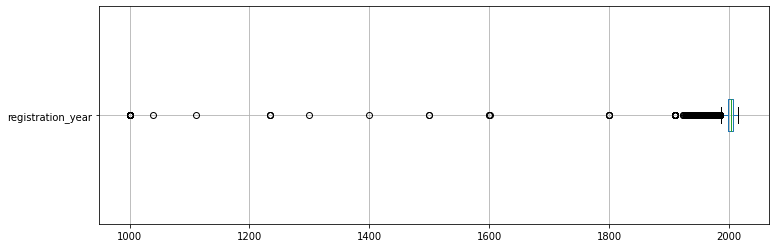

In [40]:
# Проверяем
df.boxplot('registration_year', figsize=(12,4), vert=0);

Очевидно, с 1900 года начинается область корректных значений. Рассмотрим подробнее:

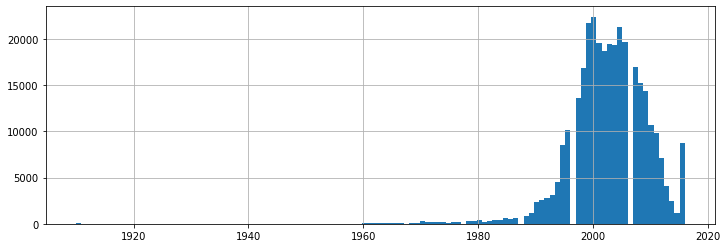

In [41]:
df.query('registration_year > 1900').registration_year.hist(bins=117, figsize=(12,4));

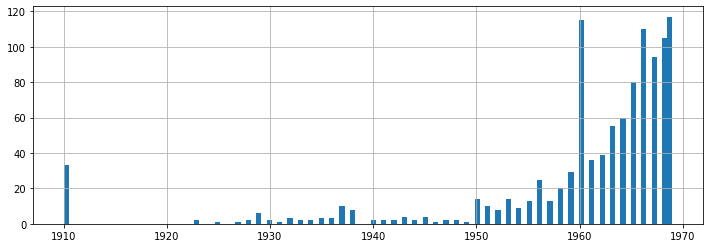

In [42]:
# Уточним данные до 1970 года
df.query('registration_year > 1900 & registration_year < 1970').registration_year.hist(bins=117, figsize=(12,4));

In [43]:
df.query('registration_year > 1900 & registration_year < 1970').sample(10)

,price,vehicle_type,registration_year,gearbox,power,model,mileage,fuel_type,brand,not_repaired
305818,8500,suv,1943,manual,76,NaN,150000,petrol,sonstige_autos,no
196700,3000,NaN,1960,NaN,0,other,5000,NaN,mercedes_benz,NaN
178303,3500,NaN,1960,manual,90,other,150000,NaN,opel,yes
309842,17900,bus,1968,NaN,0,transporter,80000,NaN,volkswagen,no
284690,11500,sedan,1954,NaN,150,other,125000,petrol,chevrolet,no
212384,10500,suv,1963,manual,200,NaN,90000,petrol,sonstige_autos,no
257676,13700,convertible,1968,manual,0,NaN,125000,petrol,sonstige_autos,no
154857,4900,coupe,1965,manual,75,other,40000,petrol,volvo,no
330517,15000,coupe,1964,NaN,45,NaN,70000,petrol,sonstige_autos,no
44430,5000,convertible,1968,auto,320,other,150000,petrol,ford,no


Данные выглядят корректными, но снова в полученной выборке имеем большое количество пропусков, а также аномально низкие цены. На гистограмме также наблюдаем резкое снижение количества автомобилей старше 1950 года. Такие автомобили внутри одной модели могут иметь совершенно разные цены, так как состояние может варьироваться от "не на ходу" до восстановленного музейного экспоната. Такие объекты являются шумом и могут снизить качество моделей. Заказчик должен осознавать, что стоимость ретро-автомобилей рассчитывается индивидуально.

Принимаем решение избавиться от автомобилей до 1960 года в датафрейме.

In [44]:
df = df.query('registration_year >= 1960')

In [45]:
df

,price,vehicle_type,registration_year,gearbox,power,model,mileage,fuel_type,brand,not_repaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,land_rover,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,land_rover,no
...,...,...,...,...,...,...,...,...,...,...
354359,1150,bus,2000,manual,0,zafira,150000,petrol,opel,no
354361,2200,NaN,2005,NaN,0,NaN,20000,NaN,sonstige_autos,NaN
354362,1199,convertible,2000,auto,101,fortwo,125000,petrol,smart,no
354363,9200,bus,1996,manual,102,transporter,150000,gasoline,volkswagen,no


Рассмотрим мощности двигателей:

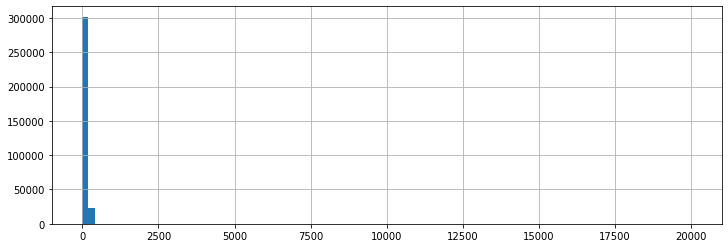

In [46]:
df.power.hist(bins=100, figsize=(12,4));

Выбросы слишком редкие, рассмотрим высокие значения подробнее:

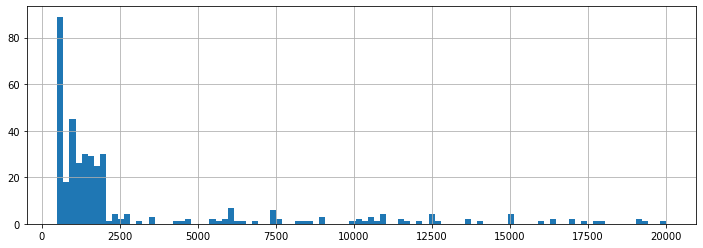

In [47]:
df.query('power > 500').power.hist(bins=100, figsize=(12,4));

In [48]:
df.query('power > 500')

,price,vehicle_type,registration_year,gearbox,power,model,mileage,fuel_type,brand,not_repaired
1816,3200,small,2004,manual,1398,corolla,5000,petrol,toyota,no
4060,3100,sedan,2005,manual,953,colt,150000,gasoline,mitsubishi,no
5328,500,wagon,1999,manual,1001,astra,150000,petrol,opel,NaN
6296,599,small,2002,manual,603,matiz,5000,petrol,chevrolet,yes
6504,3000,small,2009,manual,771,punto,125000,petrol,land_rover,NaN
...,...,...,...,...,...,...,...,...,...,...
348879,7500,sedan,2011,manual,1548,scenic,90000,petrol,land_rover,NaN
348964,250,small,1999,manual,1241,ypsilon,150000,petrol,lancia,yes
351943,1500,bus,2001,manual,1001,zafira,5000,gasoline,opel,no
353629,2400,sedan,2007,manual,650,c2,150000,petrol,land_rover,NaN


Возможно, некоторые пользователи ошибочно вводили данные по крутящему моменту или иную информацию вместо мощности двигателя в лошадиных силах. Судя по распределению, имеется около 90 автомобилей с мощностью около 500, что является возможным, но сомнительным. Принимаем решение удалить верхние 0.15% значений.

In [49]:
# Проверяем, насколько адекватно взят предел
df.power.quantile(.9985)

450.0

In [50]:
df = df.query('power <= 450')

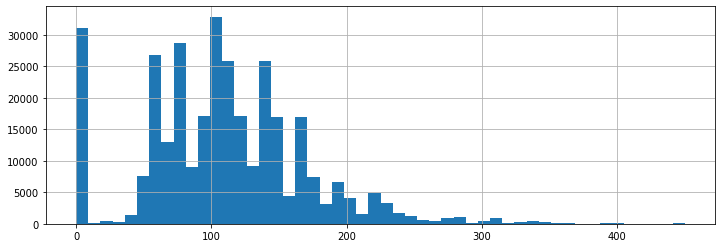

In [51]:
df.power.hist(bins=50, figsize=(12,4));

Остались околонулевые значения, проверим их:

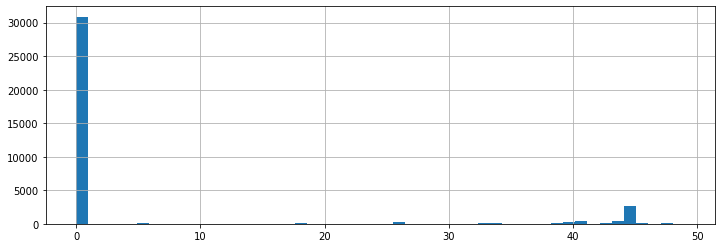

In [52]:
df.query('power < 50').power.hist(bins=50, figsize=(12,4));

При значении 45 имеется небольшой пик, также присутствует большое количество нулевых значений. Остальные значения распределены по всему диапазону, но их слишком мало. Так как мощность является количественным признаком, мы не можем заменить значения до 45 на "no_info", поэтому удаляем объекты с низкой мощностью.

In [53]:
df = df.query('power >= 45')

Как заявляли ранее, восстановить данные мощности двигателя по другим признакам невозможно, так как одна модель автомобиля в одно время может выпускаться с различными двигателями.

In [54]:
df.isna().sum()

price                    0
vehicle_type         10485
registration_year        0
gearbox               4989
power                    0
model                10595
mileage                  0
fuel_type            14887
brand                    0
not_repaired         41520
dtype: int64

Количество пропусков сильно снизилось после очистки данных, но их количество остаётся существенным. Принимаем решение заполнить пропуски заглушкой. Параллельно сохраним датафрейм, в котором все пропуски удалены и применим его, если качество моделей будет неприемлемым.

In [55]:
df_0 = df.dropna()
df_0 = df_0.reset_index(drop=True)

In [56]:
df_0

,price,vehicle_type,registration_year,gearbox,power,model,mileage,fuel_type,brand,not_repaired
0,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
1,3600,small,2008,manual,69,fabia,90000,gasoline,land_rover,no
2,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes
3,2200,convertible,2004,manual,109,2_reihe,150000,petrol,peugeot,no
4,2000,sedan,2004,manual,105,3_reihe,150000,petrol,mazda,no
...,...,...,...,...,...,...,...,...,...,...
230639,1490,small,1998,manual,50,lupo,150000,petrol,volkswagen,no
230640,7900,sedan,2010,manual,140,golf,150000,gasoline,land_rover,no
230641,3200,sedan,2004,manual,225,leon,150000,petrol,seat,yes
230642,1199,convertible,2000,auto,101,fortwo,125000,petrol,smart,no


От изначальных 354369 строк осталось 229100. Утеряно много данных, но количества объектов достаточно для дальнейшей работы.

В основном датафрейме заполним пропуски. Так как пропуски имеются только в признаках с текстовыми значениями, заполним их строкой:

In [57]:
df = df.fillna('no_info')
df = df.reset_index(drop=True)

In [58]:
# Проверяем
df.isna().sum()

price                0
vehicle_type         0
registration_year    0
gearbox              0
power                0
model                0
mileage              0
fuel_type            0
brand                0
not_repaired         0
dtype: int64

In [59]:
print('Утеряно', 354369 - df.shape[0], 'строк')

Утеряно 62646 строк


### Вывод

Провели изучение и предобработку данных. По итогу обработки были внесены следующие изменения:
1. Удалили несвязанные с ценой признаки;
2. Заменили значения на корректные для автомобилей бренда Land Rover;
3. Избавились от некорректных значений в целевом признаке;
4. Избавились от некорректных и неактуальных значений в признаке с годом регистрации;
5. Избавились от некорректных значений в признаке мощности двигателя;
6. Заполнили пропуски значением 'no_info'.

Дополнительно была создана копия итогового датафрейма, но без признаков с пропусками.

Ретро-автомобили удалены из датафрейма, расчёт стоимости автомобилей старше 1960 года рекомендуем проводить индивидуально на основании экспертной оценки.

In [60]:
#КОД РЕВЬЮЕРА

df.describe()

,price,registration_year,power,mileage
count,291723.000000,291723.000000,291723.000000,291723.000000
mean,4901.086219,2002.949349,121.374410,128493.776631
std,4610.764919,6.291644,52.801996,36501.767025
min,150.000000,1960.000000,45.000000,5000.000000
25%,1390.000000,1999.000000,80.000000,125000.000000
50%,3200.000000,2003.000000,114.000000,150000.000000
75%,6999.000000,2007.000000,150.000000,150000.000000
max,20000.000000,2016.000000,450.000000,150000.000000


## Обучение моделей

Так как требуется решение задачи регрессии, необходимо закодировать категориальные признаки. Так как они несравнимы между собой, закодируем их методом прямого кодирования.

In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 291723 entries, 0 to 291722
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              291723 non-null  int64 
 1   vehicle_type       291723 non-null  object
 2   registration_year  291723 non-null  int64 
 3   gearbox            291723 non-null  object
 4   power              291723 non-null  int64 
 5   model              291723 non-null  object
 6   mileage            291723 non-null  int64 
 7   fuel_type          291723 non-null  object
 8   brand              291723 non-null  object
 9   not_repaired       291723 non-null  object
dtypes: int64(4), object(6)
memory usage: 22.3+ MB


In [62]:
df_prep = pd.get_dummies(df, drop_first=True)

In [65]:
# Создаём переменные
features = df_prep.drop(['price'], axis=1)
target = df_prep.price

# Разделяем выборки
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=777)

In [66]:
print(features_train.columns)

Index(['registration_year', 'power', 'mileage', 'vehicle_type_convertible',
       'vehicle_type_coupe', 'vehicle_type_no_info', 'vehicle_type_other',
       'vehicle_type_sedan', 'vehicle_type_small', 'vehicle_type_suv',
       ...
       'brand_smart', 'brand_sonstige_autos', 'brand_subaru', 'brand_suzuki',
       'brand_toyota', 'brand_trabant', 'brand_volkswagen', 'brand_volvo',
       'not_repaired_no_info', 'not_repaired_yes'],
      dtype='object', length=310)


In [67]:
# Проверим размер выборок

print(features_train.shape)
print(features_test.shape)
print(features_test.shape[0] / df_prep.shape[0])

(218792, 310)
(72931, 310)
0.2500008569773381


Масштабируем данные:

In [68]:
# Стандартизируем признаки, которые изначально были количественными, выделим их
numeric = ['registration_year', 'power', 'mileage']

In [69]:
%%time

scaler = StandardScaler()
scaler.fit(features_train[numeric])

features_train_scaled = features_train
features_test_scaled = features_test

features_train_scaled[numeric] = scaler.transform(features_train[numeric])
features_test_scaled[numeric] = scaler.transform(features_test[numeric])

CPU times: user 128 ms, sys: 8.36 ms, total: 136 ms
Wall time: 132 ms


<timed exec>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
<timed exec>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retur

Так как наша основная метрика качества - RMSE, напишем функции для поиска лучшей модели.

In [70]:
def rmse(target, predictions):
    mse = mean_squared_error(target, predictions)
    return mse ** 0.5

In [71]:
rmse_score = make_scorer(rmse, greater_is_better=False)

In [72]:
def cross_val(model, params, features_train, features_test, target_train, target_test):
    grid = GridSearchCV(model, param_grid=params, cv=3, scoring=rmse_score, n_jobs=1)
    grid.fit(features_train, target_train)
    predict = grid.predict(features_test)
    return print(rmse(target_test, predict), model.get_params())

### DecisionTreeRegressor

Рассмотрим использование модели дерева решений, измерим время обучения.

In [73]:
%%time

model_dtr = DecisionTreeRegressor(random_state=777, max_depth=10)
model_dtr.fit(features_train, target_train)

CPU times: user 3.75 s, sys: 186 ms, total: 3.94 s
Wall time: 3.94 s


DecisionTreeRegressor(max_depth=10, random_state=777)

Измерим время предсказаний:

In [74]:
%%time

predict_dtr_train = model_dtr.predict(features_train)

CPU times: user 199 ms, sys: 185 ms, total: 384 ms
Wall time: 387 ms


In [75]:
rmse(target_train, predict_dtr_train)

1889.6277652571143

In [76]:
#dtr_params = {'max_depth': range(1, 10, 2)}

In [77]:
#%%time

#dtr_best_model = cross_val(model_dtr, dtr_params, features_train, features_test, target_train, target_test)

Время обучения - 3.75 сек.

Время предсказания на обучающей выборке - 0.148 сек.

RMSE - 1889.6.

### RandomForestRegressor

Рассмотрим модель случайного леса. Проведём аналогичные измерения.

In [78]:
model_rfr = RandomForestRegressor(random_state=777, max_depth=10)

In [79]:
%%time

model_rfr.fit(features_train, target_train)

CPU times: user 4min 8s, sys: 527 ms, total: 4min 9s
Wall time: 4min 9s


RandomForestRegressor(max_depth=10, random_state=777)

In [80]:
%%time

predict_rfr_train = model_rfr.predict(features_train)

CPU times: user 2.49 s, sys: 200 ms, total: 2.69 s
Wall time: 2.7 s


In [81]:
rmse(target_train, predict_rfr_train)

1815.6856195345626

Время обучения - 267 сек.

Время предсказания на обучающей выборке - 2.6 сек.

RMSE - 1815.7.

### LightGBM

Рассмотрим гиперпараметры модели LightGBM.

Для поиска эффективных гиперпараметров используем GridSearchCV.

In [82]:
grid_params = {'max_depth': range(1, 6)
              }

In [83]:
grid_lgbm = LGBMRegressor(random_state=777)
grid_model = GridSearchCV(estimator=grid_lgbm, param_grid=grid_params, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=True)

In [84]:
# Время исполнения кода - 34 минуты для поиска одного гиперпараметра
#%%time

#grid_model.fit(features_train, target_train)
#print('RMSE:', grid_model.best_score_)
#print('-'*40)
#print('Гиперпараметры:', grid_model.best_params_)

Пробуем другие значения и параметр 'cv' для поиска гиперпараметров.

In [85]:
grid_lgbm_0 = LGBMRegressor(random_state=777)
params_lgbm = {'n_estimators': [200], # сократил до известного интервала, чтобы ускорить выполнение кода
              'max_depth': [9]} # сократил до известного интервала, чтобы ускорить выполнение кода
grid_model_0 = GridSearchCV(estimator=grid_lgbm_0, param_grid=params_lgbm, cv=5, scoring=rmse_score, verbose=10)

In [86]:
%%time

grid_model_0.fit(features_train, target_train)
print(grid_model_0.best_params_)
print(abs(grid_model_0.best_score_))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5; 1/1] START max_depth=9, n_estimators=200...............................
[CV 1/5; 1/1] END .............max_depth=9, n_estimators=200; total time=  10.2s
[CV 2/5; 1/1] START max_depth=9, n_estimators=200...............................
[CV 2/5; 1/1] END .............max_depth=9, n_estimators=200; total time=   9.9s
[CV 3/5; 1/1] START max_depth=9, n_estimators=200...............................
[CV 3/5; 1/1] END .............max_depth=9, n_estimators=200; total time=  12.6s
[CV 4/5; 1/1] START max_depth=9, n_estimators=200...............................
[CV 4/5; 1/1] END .............max_depth=9, n_estimators=200; total time=  10.7s
[CV 5/5; 1/1] START max_depth=9, n_estimators=200...............................
[CV 5/5; 1/1] END .............max_depth=9, n_estimators=200; total time=   9.5s
{'max_depth': 9, 'n_estimators': 200}
1650.8396370472503
CPU times: user 1min, sys: 2.05 s, total: 1min 2s
Wall time: 1min 3s


In [87]:
%%time

grid_model_0.predict(features_train)

CPU times: user 3.41 s, sys: 282 ms, total: 3.69 s
Wall time: 3.71 s


array([2095.29848461, 4463.73517345,  807.89947567, ..., 7511.9325832 ,
       1182.78140736, 2724.06136841])

Лучший показатель RMSE - 1650.8 при гиперпараметрах 'max_depth': 9, 'n_estimators': 200.

### CatBoostRegressor

In [88]:
model_cbr = CatBoostRegressor(random_state=777, verbose=0)

params = {'iterations': [200],
          'depth': [7],
         'learning_rate': [0.1]}

grid = GridSearchCV(model_cbr, params, cv=5, scoring='neg_root_mean_squared_error', verbose=0)
grid.fit(features_train, target_train)

print('Лучшие гиперпараметры:', grid.best_params_)
print('Лучшая метрика RMSE:', abs(grid.best_score_))

Лучшие гиперпараметры: {'depth': 7, 'iterations': 200, 'learning_rate': 0.1}
Лучшая метрика RMSE: 1722.4785790948185


In [89]:
%%time

model_cbr = CatBoostRegressor(random_state=777, **grid.best_params_, verbose=0)
model_cbr.fit(features_train, target_train)

CPU times: user 8.17 s, sys: 72.5 ms, total: 8.24 s
Wall time: 8.91 s


In [90]:
%%time

model_cbr.predict(features_train)

CPU times: user 161 ms, sys: 4 ms, total: 165 ms
Wall time: 163 ms


array([2335.30218275, 4116.60028775,  986.04737175, ..., 8230.11549129,
       1240.44332975, 2720.40674266])

Лучший результат RMSE - 1749, лучшие гиперпараметры: 'depth': 7, 'learning_rate': 0.1.

Результат работы моделей на тренировочной выборке:

In [91]:
result = pd.DataFrame({'model' : ['CatBoost', 'LGBM', 'Forest', 'Tree'],
                       'time_fit' : [8.2, 336, 267, 3.86],
                       'time_pred' : [0.16, 3.38, 2.6, 0.15],
                       'RMSE' : [1537.5, 1650.8, 1815.7, 1889.6]})
result

,model,time_fit,time_pred,RMSE
0,CatBoost,8.20,0.16,1537.5
1,LGBM,336.00,3.38,1650.8
2,Forest,267.00,2.60,1815.7
3,Tree,3.86,0.15,1889.6


Для дальнейшей работы наибольшую эффективность показала модель CatBoostRegressor как по качеству, так и по времени предсказания. Проанализируем её на тестовой выборке.

## Анализ моделей

Испытаем выбранную модель на тестовой выборке:

In [92]:
%%time

prediction_test = model_cbr.predict(features_test)

CPU times: user 66 ms, sys: 34 µs, total: 66.1 ms
Wall time: 65.7 ms


In [93]:
rmse(prediction_test, target_test)

1712.0283346540095

На тестовой выборке модель, построенная по алгоритму CatBoostRegressor, имеет низкую ошибку - 1712 при допустимом пределе RMSE 2500. Полученную модель модем рекомендовать заказчику для прогнозирования стоимости автомобилей.

### Вывод

В ходе работы построили четыре модели для предсказания стоимостей автомобилей с целевой метрикой RMSE, а также с упором на время обучения и время предсказания моделей.

Модель, построенная по алгоритму CatBoostRegressor показала наилучший результат на тестовой выборке по качеству модели - RMSE = 1712, что является приемлемым результатом, входящим в требуемые рамки. Время обучения модели - низкое, 8.2 секунды. При увеличении времени обучения повысится точность модели.

Модель LightGBM достигла показателя RMSE за 11.5 секунд, тогда как модель CatBoost достигла этого же результата за 10.5 секунд на итерации 297. Также время предсказания модели LGBM является самым долгим.

Модели успешно справились с датафреймом с заполненными пропусками.

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнена загрузка и подготовка данных
- [x]  Выполнено обучение моделей
- [x]  Есть анализ скорости работы и качества моделей